In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [5]:
# Load the data
data = pd.read_pickle(
    "D:\\Projects\\Solar Forcasting\\Processed Data\\Pickle files\\feature_engineered_data.pkl"
)


# Splitting the data based on the date
train_data = data[data.index.year <= 2019]
test_data = data[data.index.year == 2020]

# Extract the relevant features and the target variable
selected_features = [
    "Sqrt_Sum_of_Squares",
    "pca_2",
    "DNI_freq_1.429_Hz_ws_14",
    "cluster",
    "Wind Direction",
    "DNI_pse",
    "DNI_freq_1.071_Hz_ws_14",
    "DNI_freq_weighted",
    "DNI_freq_0.357_Hz_ws_14",
    "DNI_freq_0.0_Hz_ws_14",
]
X_train = train_data[selected_features].values
X_test = test_data[selected_features].values
y_train = train_data["DNI"].values
y_test = test_data["DNI"].values


# Function to format data for CNN
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i : (i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


# Create datasets for CNN using a window size of 24
time_steps = 24
X_train_cnn, y_train_cnn = create_dataset(X_train, y_train, time_steps)
X_test_cnn, y_test_cnn = create_dataset(X_test, y_test, time_steps)

In [13]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to be tuned
    filters = trial.suggest_int("filters", 32, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid", "tanh"])
    pool_size = trial.suggest_int("pool_size", 2, 4)
    dense_units = trial.suggest_int("dense_units", 30, 100)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Build the CNN model
    model = Sequential()
    model.add(
        Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation=activation,
            input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]),
        )
    )
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")

    # Train the model (using a validation split for hyperparameter tuning)
    history = model.fit(
        X_train_cnn,
        y_train_cnn,
        epochs=5,
        batch_size=64,
        validation_split=0.1,
        verbose=0,
        shuffle=False,
    )

    # Return the validation loss
    return history.history["val_loss"][-1]


# Initialize an Optuna study object
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

# Print the result
print("\nBest hyperparameters:", study.best_params)

[I 2023-11-01 01:39:36,701] A new study created in memory with name: no-name-08c88d85-fa23-4db8-bc53-c4d5e0658266
[I 2023-11-01 01:40:40,128] Trial 0 finished with value: 53130.81640625 and parameters: {'filters': 84, 'kernel_size': 3, 'activation': 'sigmoid', 'pool_size': 3, 'dense_units': 34, 'learning_rate': 0.0020229975790093265}. Best is trial 0 with value: 53130.81640625.
[I 2023-11-01 01:41:39,371] Trial 1 finished with value: 101538.4375 and parameters: {'filters': 50, 'kernel_size': 5, 'activation': 'tanh', 'pool_size': 2, 'dense_units': 53, 'learning_rate': 0.00010755652082350918}. Best is trial 0 with value: 53130.81640625.
[I 2023-11-01 01:42:38,292] Trial 2 finished with value: 43962.546875 and parameters: {'filters': 44, 'kernel_size': 4, 'activation': 'sigmoid', 'pool_size': 2, 'dense_units': 96, 'learning_rate': 0.000498958348734896}. Best is trial 2 with value: 43962.546875.
[I 2023-11-01 01:44:06,482] Trial 3 finished with value: 54309.0546875 and parameters: {'filter


Best hyperparameters: {'filters': 41, 'kernel_size': 4, 'activation': 'relu', 'pool_size': 3, 'dense_units': 35, 'learning_rate': 0.0015587919197153992}


Epoch 1/100
3286/3286 [==============================] - 15s 4ms/step - loss: 4493.2236 - val_loss: 7984.1450
Epoch 2/100
3286/3286 [==============================] - 15s 4ms/step - loss: 822.2731 - val_loss: 1599.5426
Epoch 3/100
3286/3286 [==============================] - 13s 4ms/step - loss: 336.4464 - val_loss: 1056.1960
Epoch 4/100
3286/3286 [==============================] - 13s 4ms/step - loss: 259.4183 - val_loss: 642.4736
Epoch 5/100
3286/3286 [==============================] - 13s 4ms/step - loss: 207.7274 - val_loss: 508.1287
Epoch 6/100
3286/3286 [==============================] - 13s 4ms/step - loss: 154.0203 - val_loss: 147.3698
Epoch 7/100
3286/3286 [==============================] - 13s 4ms/step - loss: 144.9911 - val_loss: 134.5157
Epoch 8/100
3286/3286 [==============================] - 16s 5ms/step - loss: 140.5088 - val_loss: 102.2149
Epoch 9/100
3286/3286 [==============================] - 16s 5ms/step - loss: 114.1677 - val_loss: 83.3634
Epoch 10/100
3286/3286 [=

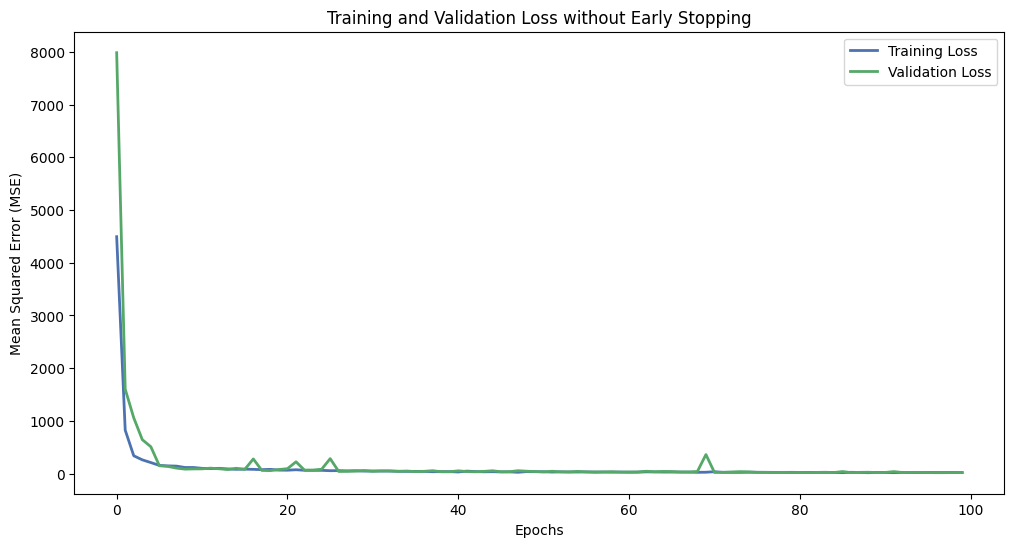

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Best hyperparameters obtained from Optuna
best_params = {
    "filters": 41,
    "kernel_size": 4,
    "activation": "relu",
    "pool_size": 3,
    "dense_units": 35,
    "dropout_rate": 0.0,  # Adding dropout rate even though it wasn't in the best hyperparameters to keep the model structure consistent
    "learning_rate": 0.0015587919197153992,
}

# Build the CNN model using the best hyperparameters
model = Sequential()
model.add(
    Conv1D(
        filters=best_params["filters"],
        kernel_size=best_params["kernel_size"],
        activation=best_params["activation"],
        input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]),
    )
)
model.add(MaxPooling1D(pool_size=best_params["pool_size"]))
model.add(Dropout(best_params["dropout_rate"]))
model.add(Flatten())
model.add(Dense(best_params["dense_units"], activation=best_params["activation"]))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss="mse")

# Train the model for 100 epochs without early stopping
history = model.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_cnn, y_test_cnn),
    verbose=1,
    shuffle=False,
)

# Visualizing training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss without Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

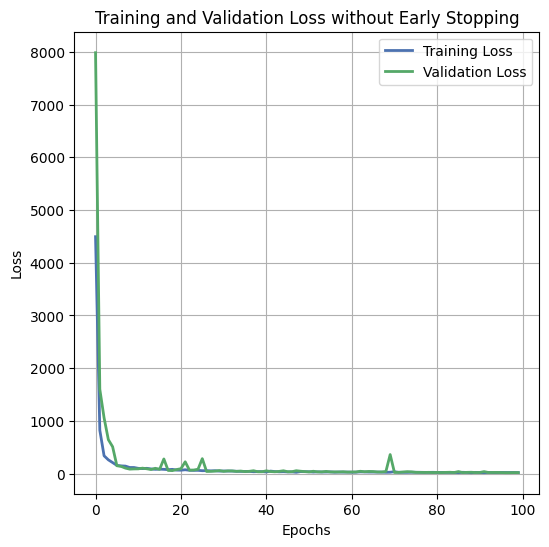

In [16]:
import matplotlib.pyplot as plt

# Visualizing training and validation loss
plt.figure(figsize=(6, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss without Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

1646/1646 [==============================] - 3s 2ms/step


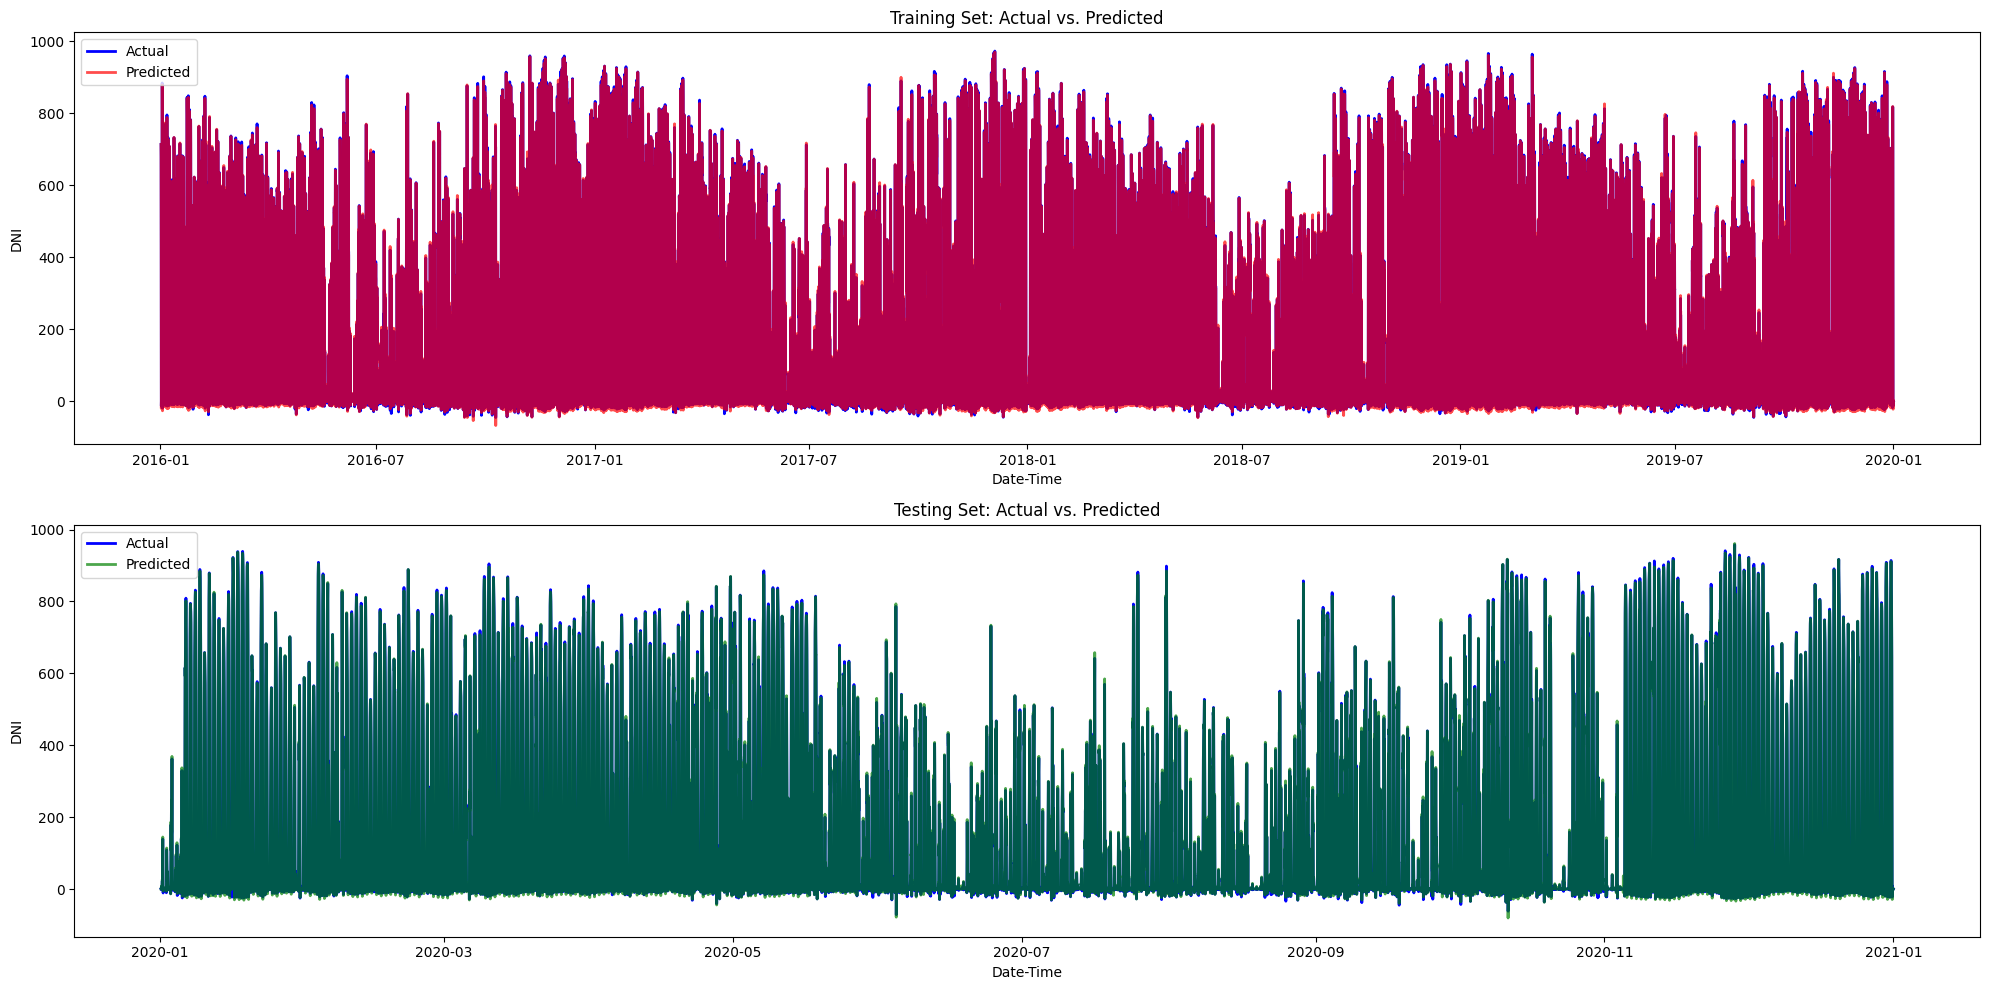

In [32]:
import matplotlib.pyplot as plt

# Making predictions on both training and testing sets
train_predictions = model.predict(X_train_cnn)
test_predictions = model.predict(X_test_cnn)

# Extracting the appropriate date-time values for the training and testing sets
train_dates = train_data["datetime"].iloc[time_steps:].values
test_dates = test_data["datetime"].iloc[time_steps:].values

# Plotting actual vs. predicted values over time for the training set
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(train_dates, y_train_cnn, color="blue", label="Actual")
plt.plot(train_dates, train_predictions, color="red", label="Predicted", alpha=0.7)
plt.title("Training Set: Actual vs. Predicted")
plt.xlabel("Date-Time")
plt.ylabel("DNI")
plt.legend()


# Plotting actual vs. predicted values over time for the testing set
plt.subplot(2, 1, 2)
plt.plot(test_dates, y_test_cnn, color="blue", label="Actual")
plt.plot(test_dates, test_predictions, color="green", label="Predicted", alpha=0.7)
plt.title("Testing Set: Actual vs. Predicted")
plt.xlabel("Date-Time")
plt.ylabel("DNI")
plt.legend()


plt.tight_layout()
plt.show()

1646/1646 [==============================] - 5s 3ms/step


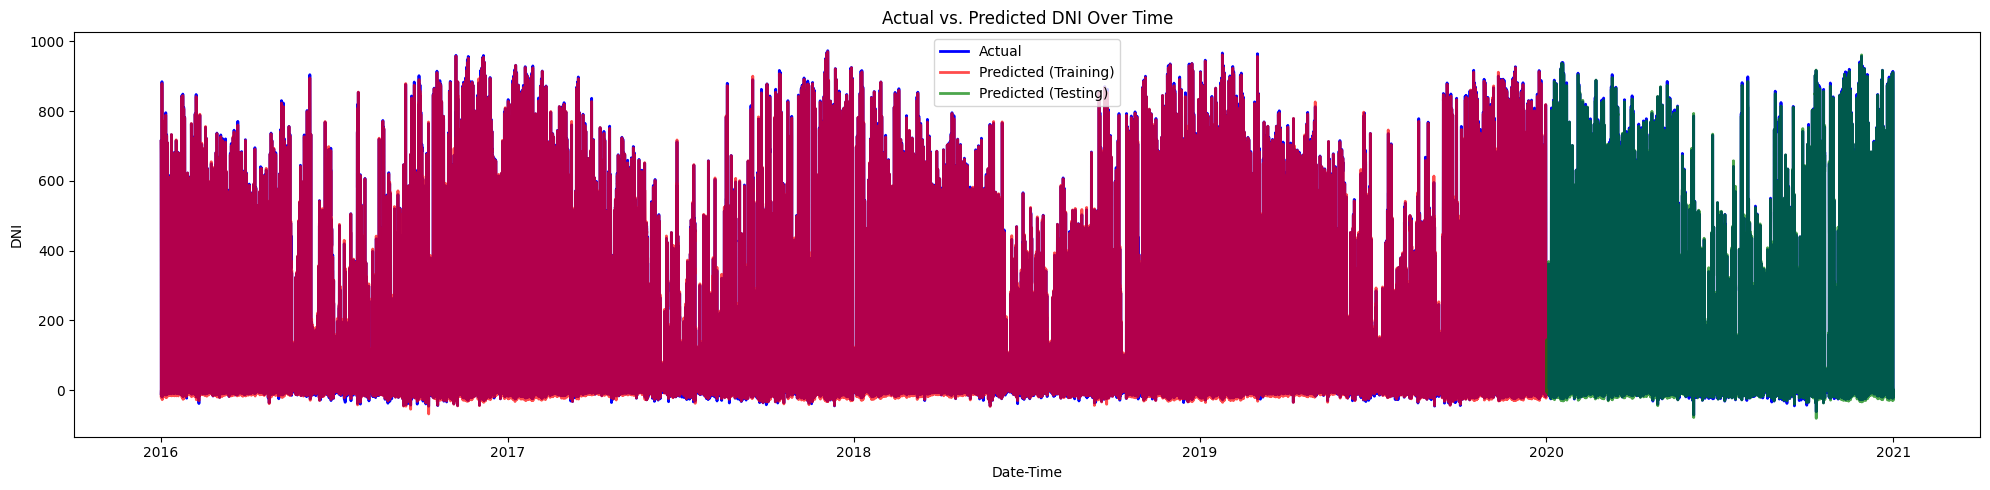

In [35]:
data.reset_index(inplace=True)
# Making predictions on both training and testing sets
train_predictions = model.predict(X_train_cnn)
test_predictions = model.predict(X_test_cnn)

# Extracting date-time values for the entire dataset
dates = data["datetime"].iloc[time_steps:].values

# Plotting actual vs. predicted values over the entire timeline
plt.figure(figsize=(20, 5))

# Plotting the actual data for the entire dataset
plt.plot(dates, data["DNI"].iloc[time_steps:].values, label="Actual", color="blue")

# Plotting the predicted training data
plt.plot(
    train_dates,
    train_predictions,
    label="Predicted (Training)",
    color="red",
    alpha=0.7,
)

# Plotting the predicted test data
plt.plot(
    test_dates, test_predictions, label="Predicted (Testing)", color="green", alpha=0.7
)

plt.title("Actual vs. Predicted DNI Over Time")
plt.xlabel("Date-Time")
plt.ylabel("DNI")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17220\3075131650.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-100, 1000], [-100, 1000], "--k", color="black")
C:\Users\user\AppData\Local\Temp\ipykernel_17220\3075131650.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-100, 1000], [-100, 1000], "--k", color="black")


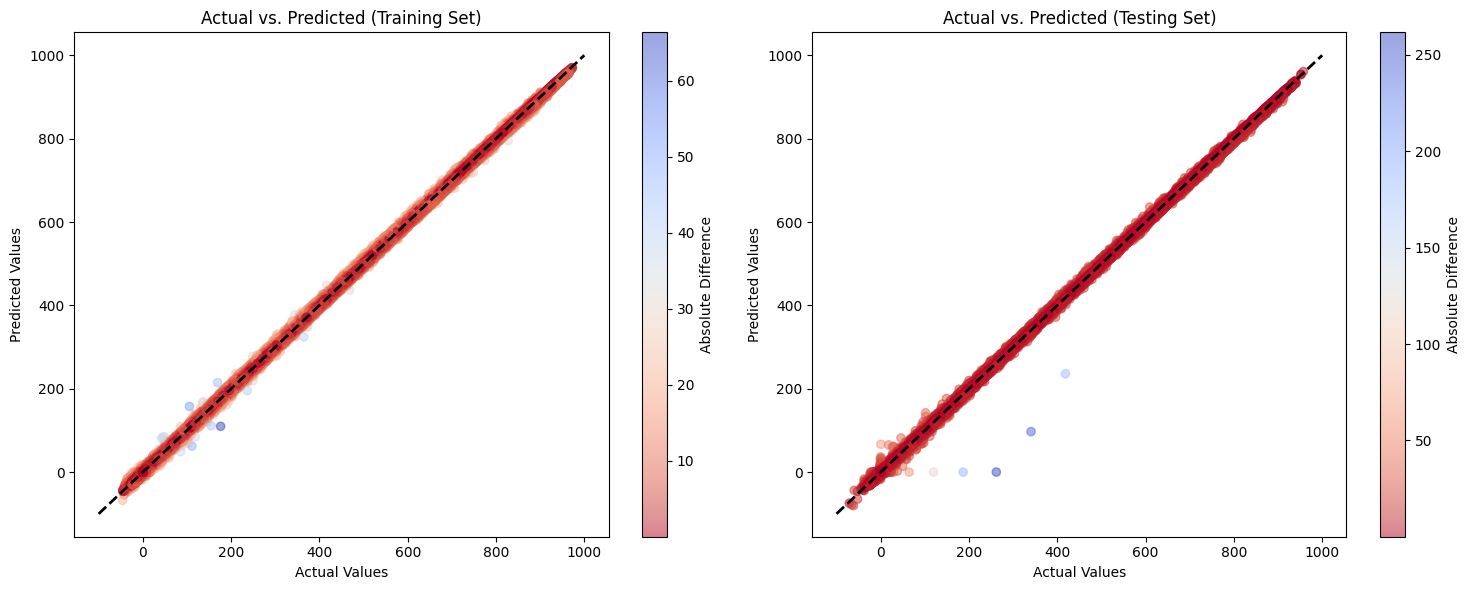

In [39]:
import numpy as np

# Calculate the absolute difference between actual and predicted values
train_diff = np.abs(y_train_cnn.flatten() - train_predictions.flatten())
test_diff = np.abs(y_test_cnn.flatten() - test_predictions.flatten())

# Plot actual vs. predicted for training set with color based on difference
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    y_train_cnn, train_predictions, c=train_diff, cmap="coolwarm_r", alpha=0.5
)
plt.colorbar(scatter, label="Absolute Difference")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted (Training Set)")
plt.plot([-100, 1000], [-100, 1000], "--k", color="black")

# Plot actual vs. predicted for testing set with color based on difference
plt.subplot(1, 2, 2)
scatter = plt.scatter(
    y_test_cnn, test_predictions, c=test_diff, cmap="coolwarm_r", alpha=0.5
)
plt.colorbar(scatter, label="Absolute Difference")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted (Testing Set)")
plt.plot([-100, 1000], [-100, 1000], "--k", color="black")

plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate error metrics for training set
mse_train = mean_squared_error(y_train_cnn, train_predictions)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_cnn, train_predictions)
r2_train = r2_score(y_train_cnn, train_predictions)

# Calculate error metrics for testing set
mse_test = mean_squared_error(y_test_cnn, test_predictions)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_cnn, test_predictions)
r2_test = r2_score(y_test_cnn, test_predictions)

# Store the results in a dataframe
results_df = pd.DataFrame(
    {
        "Dataset": ["Training", "Testing"],
        "MSE": [mse_train, mse_test],
        "RMSE": [rmse_train, rmse_test],
        "MAE": [mae_train, mae_test],
        "R^2": [r2_train, r2_test],
    }
)

results_df

,Dataset,MSE,RMSE,MAE,R^2
0,Training,11.100039,3.331672,2.153490,0.999837
1,Testing,17.028285,4.126534,2.326701,0.999767


In [41]:
reshaped_df = results_df.melt(
    id_vars=["Dataset"],
    value_vars=["MSE", "RMSE", "MAE", "R^2"],
    var_name="Metric",
    value_name="Value",
)

# Pivot the reshaped DataFrame to get the desired format
final_df = reshaped_df.pivot(
    index="Metric", columns="Dataset", values="Value"
).reset_index()

In [42]:
final_df

Dataset,Metric,Testing,Training
0,MAE,2.326701,2.153490
1,MSE,17.028285,11.100039
2,RMSE,4.126534,3.331672
3,R^2,0.999767,0.999837


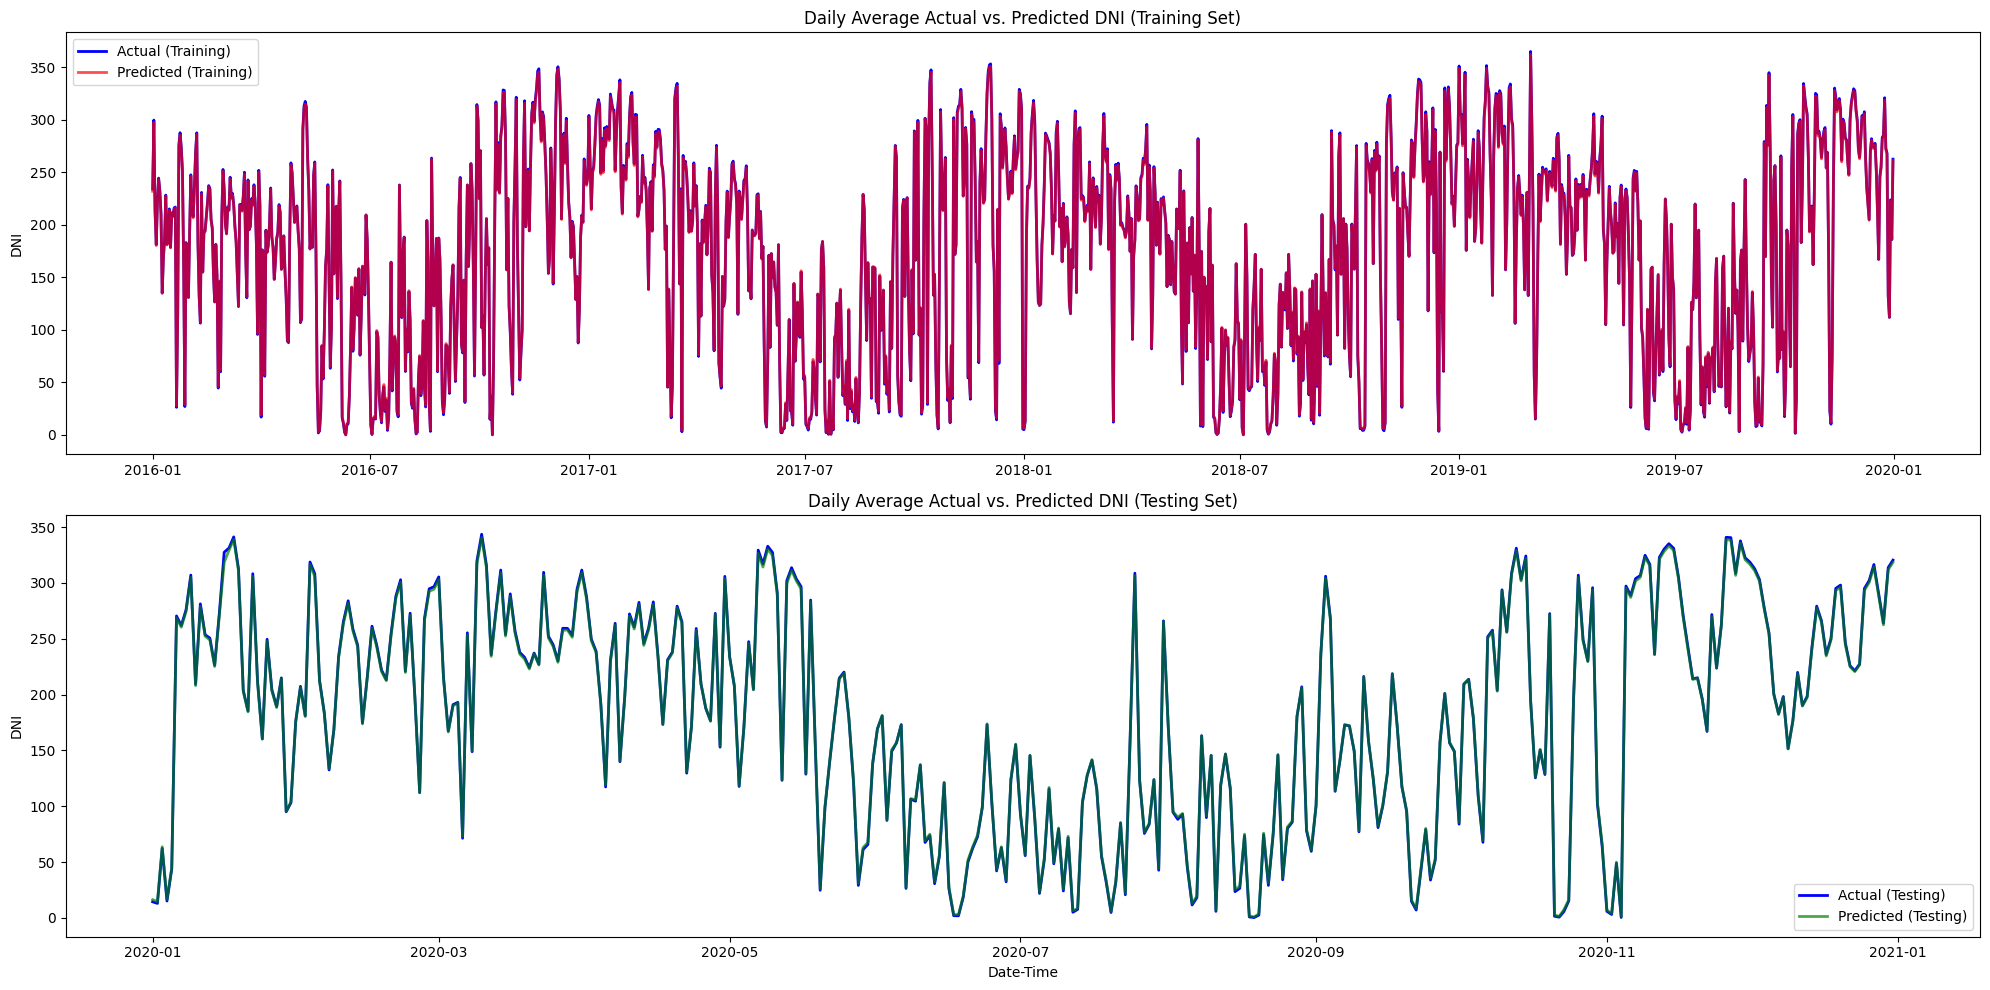

In [48]:
plt.figure(figsize=(20, 10))

# Plotting the daily averages for training data
plt.subplot(2, 1, 1)
plt.plot(
    train_daily_avg["datetime"],
    train_daily_avg["actual"],
    label="Actual (Training)",
    color="blue",
)
plt.plot(
    train_daily_avg["datetime"],
    train_daily_avg["predicted"],
    label="Predicted (Training)",
    color="red",
    alpha=0.7,
)
plt.title("Daily Average Actual vs. Predicted DNI (Training Set)")
plt.ylabel("DNI")
plt.legend()

# Plotting the daily averages for testing data
plt.subplot(2, 1, 2)
plt.plot(
    test_daily_avg["datetime"],
    test_daily_avg["actual"],
    label="Actual (Testing)",
    color="blue",
)
plt.plot(
    test_daily_avg["datetime"],
    test_daily_avg["predicted"],
    label="Predicted (Testing)",
    color="green",
    alpha=0.7,
)
plt.title("Daily Average Actual vs. Predicted DNI (Testing Set)")
plt.xlabel("Date-Time")
plt.ylabel("DNI")
plt.legend()

plt.tight_layout()
plt.show()

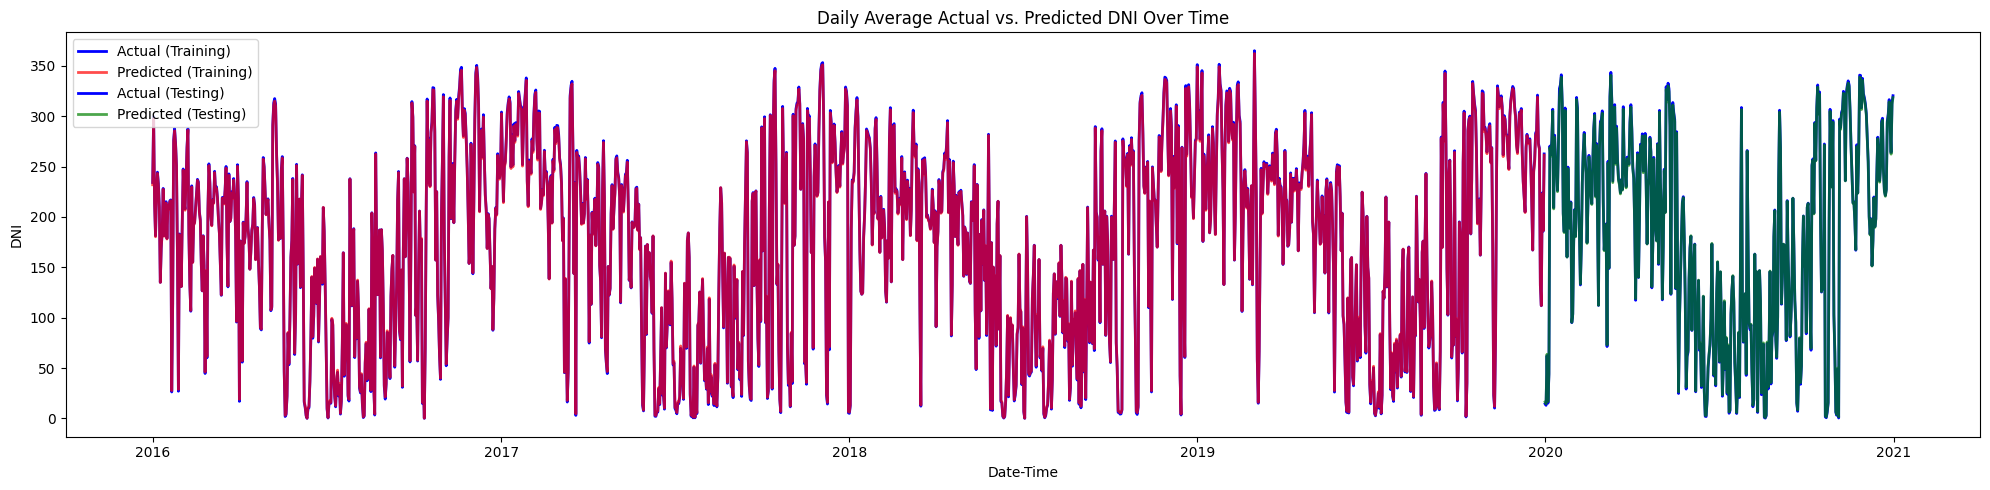

In [49]:
# Convert the actual and predicted values back to their original time intervals (every 10 minutes)
train_df = pd.DataFrame(
    {
        "datetime": train_dates,
        "actual": y_train_cnn.flatten(),
        "predicted": train_predictions.flatten(),
    }
)
test_df = pd.DataFrame(
    {
        "datetime": test_dates,
        "actual": y_test_cnn.flatten(),
        "predicted": test_predictions.flatten(),
    }
)

# Resample to compute daily average
train_daily_avg = train_df.set_index("datetime").resample("D").mean().reset_index()
test_daily_avg = test_df.set_index("datetime").resample("D").mean().reset_index()

# Plot the daily averages
plt.figure(figsize=(20, 5))

# Plotting the daily averages for training data
plt.plot(
    train_daily_avg["datetime"],
    train_daily_avg["actual"],
    label="Actual (Training)",
    color="blue",
)
plt.plot(
    train_daily_avg["datetime"],
    train_daily_avg["predicted"],
    label="Predicted (Training)",
    color="red",
    alpha=0.7,
)

# Plotting the daily averages for testing data
plt.plot(
    test_daily_avg["datetime"],
    test_daily_avg["actual"],
    label="Actual (Testing)",
    color="blue",
)
plt.plot(
    test_daily_avg["datetime"],
    test_daily_avg["predicted"],
    label="Predicted (Testing)",
    color="green",
    alpha=0.7,
)

plt.title("Daily Average Actual vs. Predicted DNI Over Time")
plt.xlabel("Date-Time")
plt.ylabel("DNI")
plt.legend()
plt.tight_layout()
plt.show()